# Toxic Comment Classification

## Table of Contents

1. [Introduction](#introduction)
2. [The Data](#data)    
    - [File Description](#file)
3. [Data Wrangling](#wrangling)
4. [Exploratory Data Analysis](#eda)
    * [Word Cloud](#wordcloud)

# <a name="introduction"></a>Introduction
---

Being anonymous over the internet can sometimes make people say nasty things that they normally would not in real life. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. Current models don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content). The goal is to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate. 

# <a name="data"></a>The Data
---

The dataset here is from wiki corpus dataset which was rated by human raters for toxicity. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate


### <a name="file"></a> File descriptions

* **train.csv** - the training set, contains comments with their binary labels
* **test.csv** - the test set, used to predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.

In [1]:
#import required packages
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as regex
from tqdm import tqdm, tqdm_pandas, tqdm_notebook

#initializing some needed objects
tqdm.pandas()
tokenizer=TweetTokenizer()
lem = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))

# <a name="wrangling"></a>Data Wrangling
---

Here I am going to load the dataset and look at the columns and some basic DataFrame info.

In [2]:
#declare the path of the data
test_data_location = 'data/test.csv'
train_data_location = 'data/train.csv'

#import the data as a DataFramae with 'id' as the index
train_df = pd.read_csv(train_data_location, index_col='id')
test_df = pd.read_csv(test_data_location, index_col='id')

In [3]:
#Look at some values in the train DF
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
#Look at some values in the test DF
test_df.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
#look at the info of the train DF and its columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [6]:
#look at the info of the test DF and its columns
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153164 entries, 00001cee341fdb12 to ffffce3fb183ee80
Data columns (total 1 columns):
comment_text    153164 non-null object
dtypes: object(1)
memory usage: 2.3+ MB


In [7]:
#fill in any null values
train_df["comment_text"].fillna("unknown", inplace=True)
test_df["comment_text"].fillna("unknown", inplace=True)

# <a name="eda"></a>Exploraty Data Analyis
---

Here I am going to do some EDA.

In [8]:
count_labels = train_df.iloc[:,2:].sum()
print(count_labels)

severe_toxic     1595
obscene          8449
threat            478
insult           7877
identity_hate    1405
dtype: int64


In [9]:
print('Total tags: ', count_labels.sum())
print('Total comments: ', len(train_df))

Total tags:  19804
Total comments:  159571


Not all comments have been tagged with one of the available tags, this indicates that the comment is not toxic. I am going to create a new column to tag these comments. 

In [10]:
#add up the tags for each comment.
rowsums = train_df.iloc[:,2:].sum(axis=1)

#if the comment has no tags then it is non-toxic
train_df['non_toxic'] = (rowsums==0) #is there a way to add it as 1 or 0 off the bat?

#convert the boolean column to 1 or 0
train_df = train_df.applymap(lambda x: 1 if x == True else x)
train_df = train_df.applymap(lambda x: 0 if x == False else x)

train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [11]:
#update the count labels
count_labels = train_df.iloc[:,2:].sum()
count_labels = count_labels.sort_values()
print(count_labels*100/len(train_df))

threat            0.299553
identity_hate     0.880486
severe_toxic      0.999555
insult            4.936361
obscene           5.294822
non_toxic        93.382883
dtype: float64


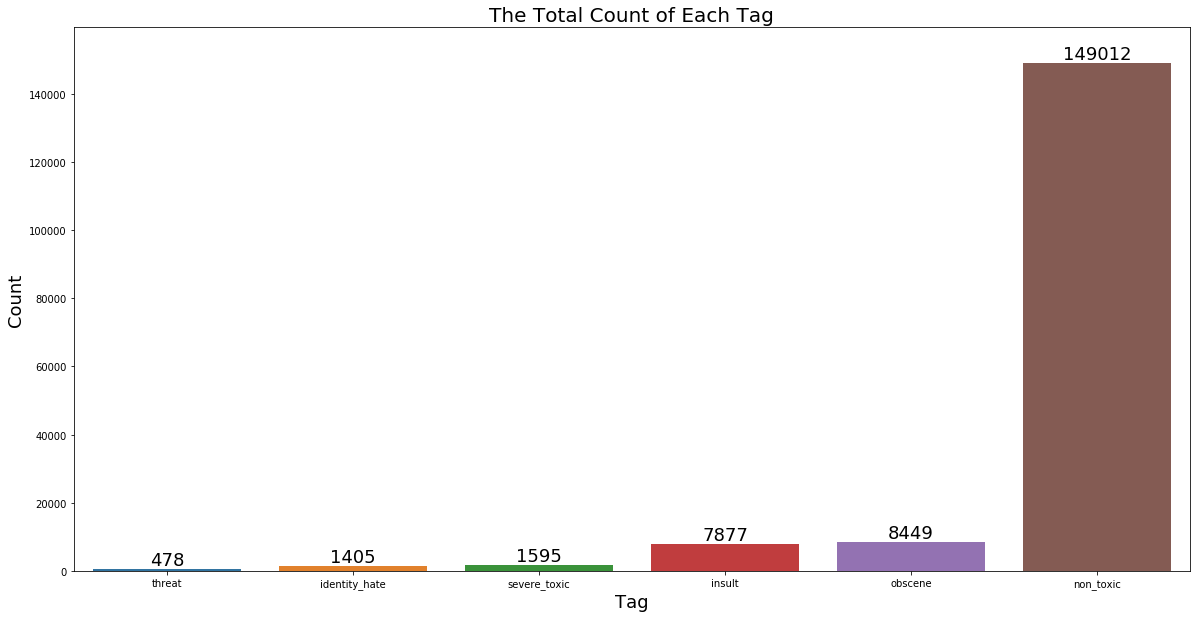

In [12]:
#plot the total to have a better look
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(count_labels.index, count_labels.values)
plt.title("The Total Count of Each Tag", fontsize=20)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Tag', fontsize=18)
plt.ylim(0,len(train_df))

#add the count to the tags
rects = ax.patches
labels = count_labels.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

In [13]:
#Check the total tags and comments again
print('Total tags: ', count_labels.sum())
print('Total comments: ', len(train_df))

Total tags:  168816
Total comments:  159571


There are more tags than total comments, this is most likely due to some comments having multiple tags. I will double check this now.

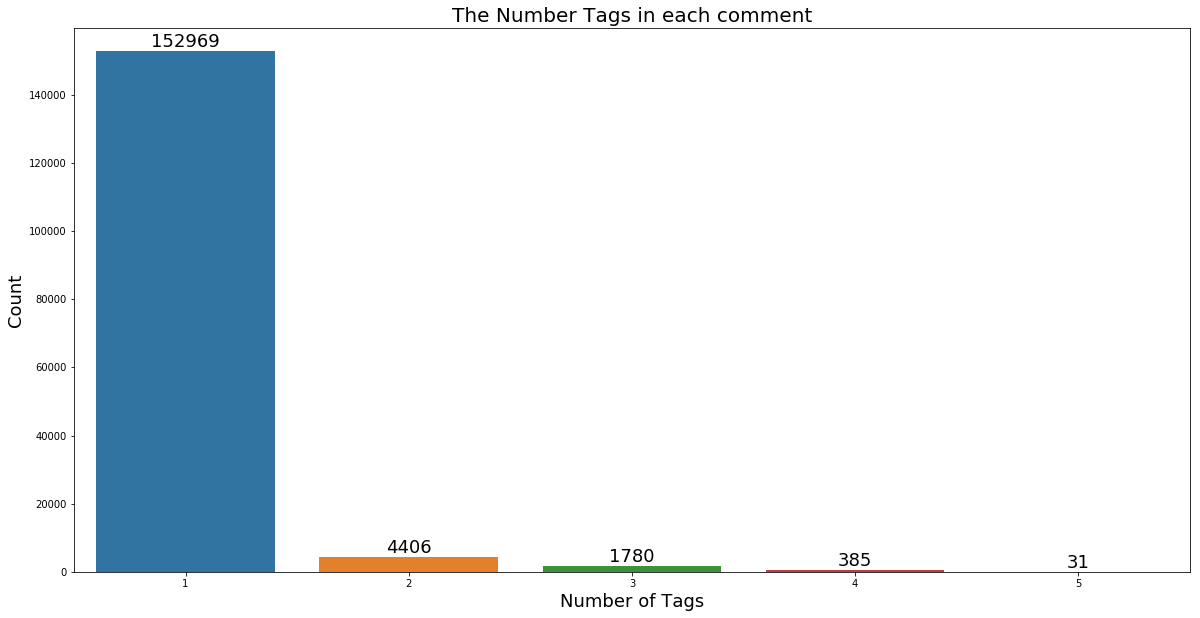

In [14]:
#plot the total count of each 
tag_count = train_df.iloc[:,2:].sum(axis=1).value_counts()
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(tag_count.index, tag_count.values)
plt.title("The Number Tags in each comment", fontsize=20)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Number of Tags', fontsize=18)
plt.ylim(0,len(train_df))

#adding the text labels
rects = ax.patches
labels = tag_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

Indeed there are a lot of comments that have several tags.

## <a name="wordcloud"></a>Word Cloud


Now lets take a look at the comments themselves. Creating a word could will help visualize what words are mostly used in ceratin comments.

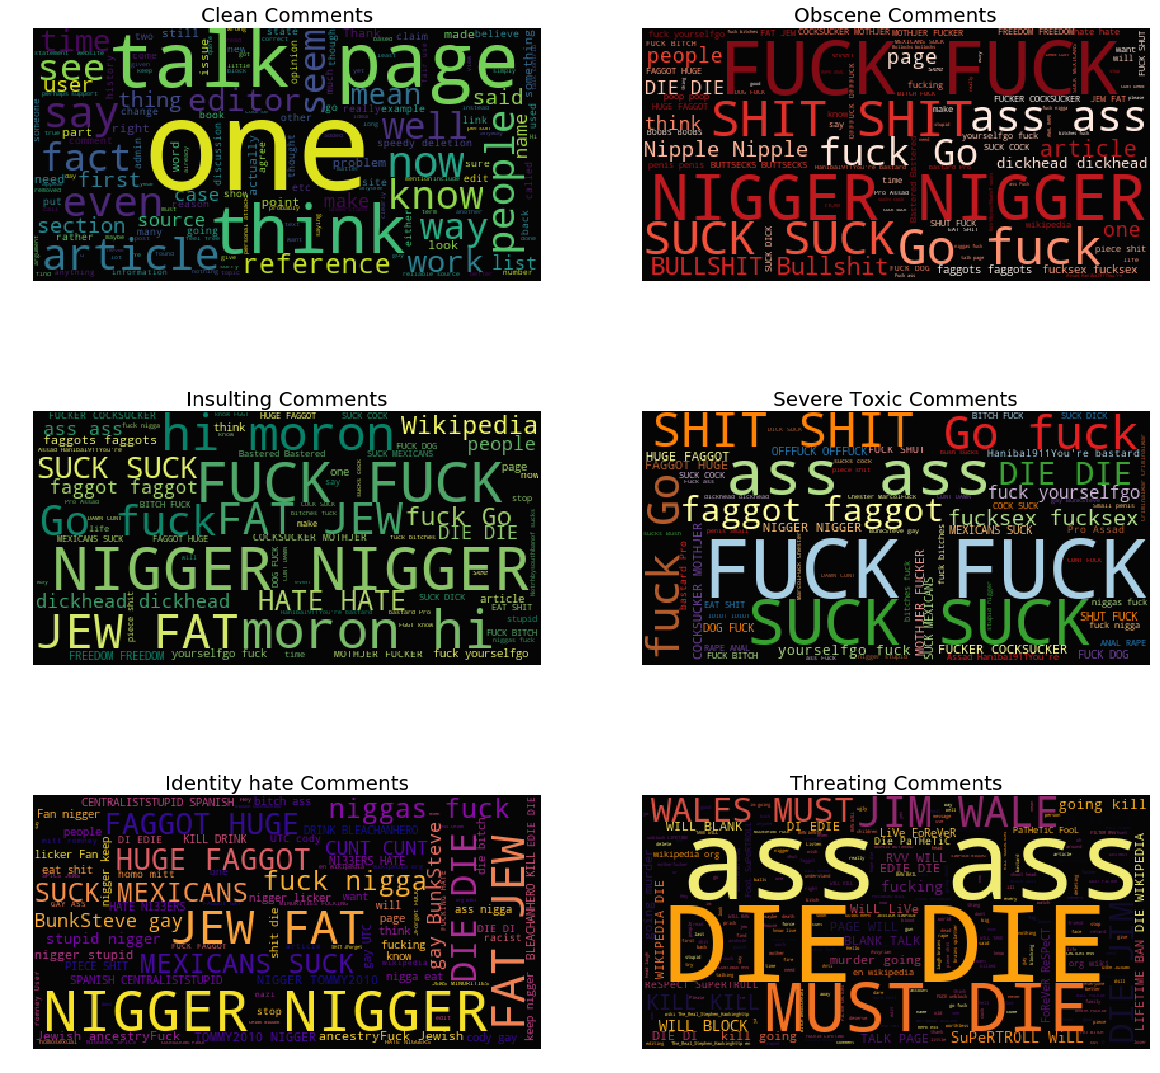

In [15]:
stopwords = set(STOPWORDS)
plt.figure(figsize=(20,20))

#Clean comments
#Get all the clean text
clean_text = train_df[train_df.non_toxic == True].comment_text.values
wc= WordCloud(background_color="black", max_words=4000, stopwords=stopwords)
wc.generate(" ".join(clean_text))
plt.subplot(321)
plt.axis("off")
plt.title("Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=244), alpha=0.98)

#Obscene comments
#Get all the obscene text
obscene_text = train_df[train_df.obscene == True].comment_text.values
wc= WordCloud(background_color="black", max_words=4000, stopwords=stopwords)
wc.generate(" ".join(obscene_text))
plt.subplot(322)
plt.axis("off")
plt.title("Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Insult comments
#Get all the insult text
insult_text = train_df[train_df.insult == True].comment_text.values
wc= WordCloud(background_color="black", max_words=4000, stopwords=stopwords)
wc.generate(" ".join(insult_text))
plt.subplot(323)
plt.axis("off")
plt.title("Insulting Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#Severe Toxic comments
#Get all the severe toxic text
severe_toxic_text = train_df[train_df.severe_toxic == True].comment_text.values
wc= WordCloud(background_color="black", max_words=4000, stopwords=stopwords)
wc.generate(" ".join(severe_toxic_text))
plt.subplot(324)
plt.axis("off")
plt.title("Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

#Identity hate comments
#Get all the identity hate text
identity_hate_text = train_df[train_df.identity_hate == True].comment_text.values
wc= WordCloud(background_color="black", max_words=4000, stopwords=stopwords)
wc.generate(" ".join(identity_hate_text))
plt.subplot(325)
plt.axis("off")
plt.title("Identity hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'plasma' , random_state=244), alpha=0.98)

#Threat comments
#Get all the threat text
threat_text = train_df[train_df.threat == True].comment_text.values
wc= WordCloud(background_color="black", max_words=4000, stopwords=stopwords)
wc.generate(" ".join(threat_text))
plt.subplot(326)
plt.axis("off")
plt.title("Threating Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'inferno' , random_state=244), alpha=0.98)

plt.show()

In [16]:
# Aphost lookup dict
apostrophe_dic = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [17]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment = comment.lower()
    
    #remove \n
    comment = regex.sub("\\n", "", comment)
    
    # remove unneeded elements like ip,user
    comment = regex.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", comment)
    
    #removing usernames
    comment = regex.sub("\[\[.*\]", "", comment)
    
    #Split the sentences into words
    words = tokenizer.tokenize(comment)
    
    #aphostophe(') replacement (you're --> you are)
    words = [apostrophe_dic[word] if word in apostrophe_dic else word for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [word for word in words if not word in eng_stopwords]
    
    clean_sent = " ".join(words)

    return(clean_sent)

In [18]:
#merge comments from train and test datasets
merged = pd.concat([train_df.iloc[:,0:1], test_df.iloc[:,0:1]], sort=True)
corpus = merged.comment_text

In [19]:
clean_corpus = corpus.progress_apply(lambda x: clean(x))

100%|████████████████████████████████| 312735/312735 [02:00<00:00, 2605.79it/s]
